# 3D Computer Vision (2024/25)

## Exercise

Upload: 30.10.2024 (11:30)

**Deadline**: 16.01.2025 (23:59)

### Your Group
Submitted by Group XX: 
- Name1
- Name2
- Name3
- Name4

By submitting this exercise, you confirm the following:
- **All people** listed above **contributed** to this solution
- **No other people** were **involved** in this solution
- **No contents** of this solution were **copied from others** (this includes people, large language models, websites, etc.)

### Submission
Please hand in a single **.zip** file named according to the pattern "**groupXX**" (e.g. group00). The contents of the .zip should be as follows:
- folder with the same name as the **.zip** file
    - **.ipynb** file
    - **.html** export of .ipynb with all the outputs you got
    - **data** folder containing necessary files to run the code

I.e.
1. **unzip** the provided project.zip file
2. **rename** folder "project" according to the pattern "groupXX"
3. **solve** task inside .ipynb file
4. **export** notebook as .html (File > Download as > HTML)
5. **zip** folder groupXX
6. **submit** groupXX.zip

### Final Presentation
You will be required to present your solution in a 20 minute presentation, which includes:
- Problem Overview
- Solution Overview (e.g. pseudo code, mathematical formulas, visualizations)
- Describe challenges & optimizations

After the presentation, there will be 10 minutes of questions and answers about your work.

# 3D Scene Reconstruction
### Task Overview
Your task in this exercise is to do a dense reconstruction of a scene. This will involve multiple steps that you will encounter and learn about as the semester progresses. You can start implementing individual steps as soon as you learn about them or wait until you have learned more to implement everything together. In the latter case, be mindful that this exercise is designed for an entire semester and the workload is accordingly large.

You will be given the following data:
- **9 color images** of the scene.
    - 8 Bit RGB per pixel.
    - Each image rendered from a different position.
    - The camera used had **lens distortion**.
- **9 Depth images** of the scene.
    - 8 Bit Grayscale per pixel. The result of dividing the Z-depth by **each image's maximum** and then multiplying by 255.
    - Each image has the **same pose** as the corresponding RGB image.
    - The camera used was **free of any distortions**.
- 1 Dictionary containing **camera calibration parameters**.
    - They belong to the camera that was used to render the RGB images.
    - Distortion coefficients are given in the standard [k<sub>1</sub>, k<sub>2</sub>, p<sub>1</sub>, p<sub>2</sub>, k<sub>3</sub>] order.
- 1 Numpy array containing **8 camera transformations**.
    - They specify the **movements** that the **camera went through** to render all images.
    - I.e. idx **0** specifies the transformation from **00.png to 01.png**, idx **1** specifies the transformation from **01.png to 02.png**, ...
    - This applies to both RGB and Depth images, as they have the same poses.
- 1 Numpy array containing **7 features**.
    - The features are specified for each of the 9 images.
    - Each feature is a **2D pixel location in "H, W" order**, meaning the first value is the height/row in the image and the second width/column.
    - If a feature was not visible, it was entered as [-1, -1].
    - The features are **unsorted**, meaning that feature idx 0 for 00.png could be corresponding to e.g. feature idx 4 for 01.png.

### Solution requirements
- Your code needs to **compile**, **run**, and produce an **output**.
- Your target output should be a **dense point cloud** reconstruction (without holes) of the scene.
    - The output should be in the **.ply format**. We provide a function that can exports a .ply file.
    - You may inspect your .ply outputs in e.g. **Meshlab**.
    - See the 'Dense Point Cloud' sample image to get an idea of what is possible. (Meshlab screenshot with point shading set to None)
- Your code should be a **general solution**.
    - This means that it could run correctly for a different dataset (with same input structure).
    - It should **NOT** include anything **hardcoded** specific to this dataset.
- Your code should not be unnecessarily inefficient.
    - Our sample solution runs in less than 2 minutes total (including point cloud export).
    - If your solution runs for more than 10 minutes, you are being wasteful in some part of your program.

# Samples
### Image Distortion
![title](data/samples/image_distortion.png)
### Cameras
![title](data/samples/cameras.png)
### Cameras & Features
![title](data/samples/features.png)
### Dense Point Cloud
![title](data/samples/dense_point_cloud.png)

# Imports
Please note the following:
- These are all imports necessary to achieve the sample results.
- You may remove and/or add other libraries at your own convinience.
- Using library functions (from the given or other libraries) that bypass **necessary computer vision tasks** will not be recognized as 'solved'.
    - E.g.: If you **need** to undistort an image to **get to the next step** of the solution and use the library function cv2.undistort(), then we will evaluate the **undistortion step** as '**failed**'.
    - E.g.: If you **want** to draw points in an image (to **check your method** or **visualize in-between steps**) and use the library function cv2.circle(), then there is **no problem**.
    - E.g.: If you **need** to perform complex **mathematical** operations and use some numpy function, then there is **no problem**.
    - E.g.: You do not like a **provided utility function** and find/know a library function that gives the **same outputs** from the **same inputs**, then there is **no problem**.

In [6]:
import os
import torch
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
#make plots interactive:
%matplotlib inline

# Prepare Data
This should load all available data and also create some output directories. Feel free to rename variables or add additional directories as you see fit.

In [7]:
#Inputs
base_path = os.getcwd()
data_path = os.path.join(base_path, f"data")
img_path = os.path.join(data_path, 'images')
depth_path = os.path.join(data_path, 'depths')
print(f"The project's root path is '{base_path}'.")
print(f"Reading data from '{data_path}'.")
print(f"Image folder: '{img_path}'.")
print(f"Depth folder: '{depth_path}'.")

#Outputs
out_path = os.path.join(base_path, 'output')
ply_path = os.path.join(out_path, 'point_cloud')
os.makedirs(out_path, exist_ok=True)
os.makedirs(ply_path, exist_ok=True)
print(f"\nCreating directory '{out_path}'.")
print(f"Creating directory '{ply_path}'.")

#Load Data
camera_calibration = np.load(os.path.join(data_path, 'camera_calibration.npy'), allow_pickle=True)
camera_calibration = camera_calibration.item()#get dictionary from numpy array struct
given_features = np.load(os.path.join(data_path, 'given_features.npy'), allow_pickle=True)
camera_movement = np.load(os.path.join(data_path, 'camera_movement.npy'), allow_pickle=True)

print(f"\nCamera Calibration:")
for entry in camera_calibration.items():
    print(f"  {entry[0]}: {entry[1]}")
print(f"Camera Movement: {camera_movement.shape}")#[Cameras-1, 4, 4]
print(f"2D Features (Unsorted): {given_features.shape}")#[Camera_idx, Feature_idx, 2]

The project's root path is 'c:\RPTU Sem 1\3D-CV\project'.
Reading data from 'c:\RPTU Sem 1\3D-CV\project\data'.
Image folder: 'c:\RPTU Sem 1\3D-CV\project\data\images'.
Depth folder: 'c:\RPTU Sem 1\3D-CV\project\data\depths'.

Creating directory 'c:\RPTU Sem 1\3D-CV\project\output'.
Creating directory 'c:\RPTU Sem 1\3D-CV\project\output\point_cloud'.

Camera Calibration:
  distortion_param: [-0.1, 0.02, 0.0, 0.0, -0.01]
  image_height: 551
  image_width: 881
  principal_point: [275.0, 440.0]
  focal_length_mm: 25
  sensor_width_mm: 35
  pixel_ratio: 1.0
  pixel_per_mm: 25.17142857142857
  focal_length_px: 629.2857142857142
Camera Movement: (8, 4, 4)
2D Features (Unsorted): (9, 7, 2)


# Provided Utility Functions
These functions are provided to reduce the complexity of some steps you might encounter. They were involved in the creation of the given samples. However, you do not have to use them and can use other means of achieving the same results.

In [8]:
def sample_image(numpy_image, numpy_sample_grid):
    '''
    This function samples a target image from a source image (numpy_image) based on specified pixel coordinates (numpy_sample_grid).
    Inputs:
        numpy_image: of shape=[H, W, C]. H is the height, W is the width, and C is the color channel of the source image from which color values will be sampled.
        numpy_sample_grid: of shape=[H, W, UV]. H is the height and W is the width of the target image that will be sampled. UV are the pixel locations in the source image from which to sample color values.
    Outputs:
        sampled_image: of shape=[H, W, C]. H is the height, W is the width, and C is the color channel of the target image that was sampled.
    '''
    height, width, _ = numpy_image.shape#[H, W, 3]

    #turn numpy array to torch tensor
    torch_sample_grid = torch.from_numpy(numpy_sample_grid)#[H, W, 2]
    #normalize from range (0, width-1) to (0, 1)
    torch_sample_grid[:, :, 0] = torch_sample_grid[:, :, 0] / (width-1)
    #normalize from range (0, height-1) to (0, 1)
    torch_sample_grid[:, :, 1] = torch_sample_grid[:, :, 1] / (height-1)
    #normalize from range (0, 1) to (-1, 1)
    torch_sample_grid = torch_sample_grid*2 -1

    #transform to necessary shapes
    torch_sample_grid = torch_sample_grid.unsqueeze(0)#[1, H, W, 2]
    torch_image = torch.from_numpy(numpy_image).double().permute(2, 0, 1).unsqueeze(0)#[1, 3, H, W]
    #sample image according to sample grid locations from source image
    sampled_image = torch.nn.functional.grid_sample(torch_image, torch_sample_grid, mode='bilinear', padding_mode='zeros', align_corners=True)
    #transform back to numpy image
    sampled_image = sampled_image.squeeze().permute(1, 2, 0).numpy().astype(np.uint8)#[H, W, 3]
    return sampled_image

def ply_creator(input_3d, rgb_data=None, filename='dummy'):
    ''' Creates a colored point cloud that you can visualise using e.g. Meshlab.
    Inputs:
        input_3d: of shape=[N, 3], each row is the 3D coordinate of each point
        rgb_data(optional): of shape=[N, 3], each row is the rgb color value of each point
        filename: file name for the .ply file to be created 
    '''
    assert (input_3d.ndim==2),"Pass 3d points as NumPointsX3 array "
    pre_text1 = """ply\nformat ascii 1.0"""
    pre_text2 = "element vertex "
    pre_text3 = """property float x\nproperty float y\nproperty float z\nproperty uchar red\nproperty uchar green\nproperty uchar blue\nend_header"""
    pre_text22 = pre_text2 + str(input_3d.shape[0])
    pre_text11 = pre_text1
    pre_text33 = pre_text3
    filename = filename + '.ply'
    fid = open(filename, 'w')
    fid.write(pre_text11)
    fid.write('\n')
    fid.write(pre_text22)
    fid.write('\n')
    fid.write(pre_text33)
    fid.write('\n')
    for i in range(input_3d.shape[0]):
        for c in range(3):
            fid.write(str(input_3d[i,c]) + ' ')
        if not rgb_data is None:
            for c in range(3):
                fid.write(str(rgb_data[i,c]) + ' ')
        if i!=input_3d.shape[0]:
            fid.write('\n')
    fid.close()
    return filename

In [9]:
#The following is a simple toy example to see the behavior of the sample_image function
example_source = (np.random.rand(110, 220, 3)*255).astype(int)#[110, 220, 3]
example_grid = np.ones([100, 200, 2])#[100, 200, 2]
example_grid[:, :, 1] = 2
example_target = sample_image(example_source, example_grid)#[100, 200, 3]

#example_target will be of shape [100, 200, 3]
#100, because example_grid has a height of 100
#200, because example_grid has a width of 200
#3, because example_source has a color channel of 3
print(example_source.shape)

#example_target will contain the value of example_source[2, 1] at every pixel
#2, because example_grid[:, :, 1] has a value of 2 for every pixel
#1, because example_grid[:, :, 0] has a value of 1 for every pixel
print(example_source[2, 1, 0], "->", np.unique(example_target[:, :, 0]))
print(example_source[2, 1, 1], "->", np.unique(example_target[:, :, 1]))
print(example_source[2, 1, 2], "->", np.unique(example_target[:, :, 2]))

(110, 220, 3)
222 -> [222]
165 -> [165]
128 -> [128]


# Percieving the Inputs:

In [10]:
# Camera Calibration:#
print("\nCamera Calibration:")
for param, value in camera_calibration.items():
    print(f"{param}: {value}")


Camera Calibration:
distortion_param: [-0.1, 0.02, 0.0, 0.0, -0.01]
image_height: 551
image_width: 881
principal_point: [275.0, 440.0]
focal_length_mm: 25
sensor_width_mm: 35
pixel_ratio: 1.0
pixel_per_mm: 25.17142857142857
focal_length_px: 629.2857142857142


In [11]:
# Camera Movement:
print(f"\nCamera Movement: {camera_movement.shape}: Frame 0 to 1 , 1 to 2, ..., 8 to 9. \nMatrices Describing ROtation and Translation from one frame to next.\n")
print(f"eg. Camera Movement from Frame 0 to 1 (homogeneous) = [R|T]:\n{camera_movement[0]}")


Camera Movement: (8, 4, 4): Frame 0 to 1 , 1 to 2, ..., 8 to 9. 
Matrices Describing ROtation and Translation from one frame to next.

eg. Camera Movement from Frame 0 to 1 (homogeneous) = [R|T]:
[[ 0.70710678 -0.1830127   0.6830127  -3.        ]
 [ 0.1830127   0.98037987  0.0732233  -0.25881905]
 [-0.6830127   0.0732233   0.72672691  0.96592583]
 [ 0.          0.          0.          1.        ]]


In [12]:
# 2D Features (Unsorted):
print(f"\n2D Features (Unsorted): {given_features.shape}: [Camera_idx, Feature_idx, 2].\n")
print(f"eg. 2D Feature extracted for pose 0: \n{given_features[0]}")


2D Features (Unsorted): (9, 7, 2): [Camera_idx, Feature_idx, 2].

eg. 2D Feature extracted for pose 0: 
[[163 616]
 [431 593]
 [380 672]
 [164 660]
 [378 462]
 [280 422]
 [274 650]]


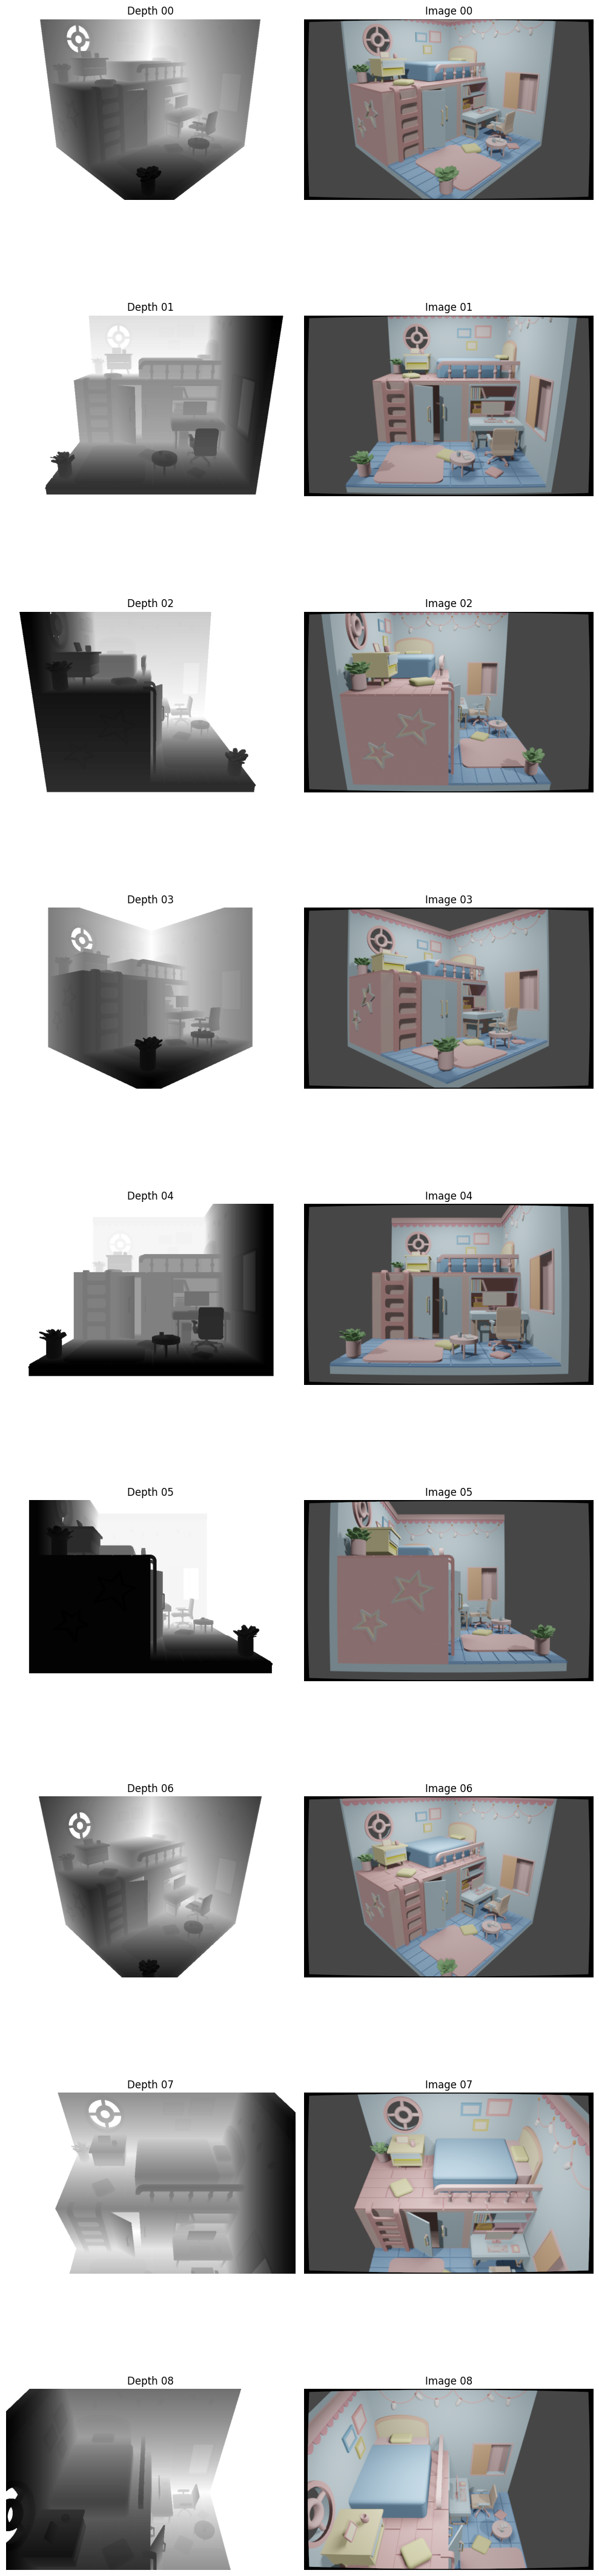

In [13]:
plt.figure(figsize=(10, 45))  # Adjust the figure size as needed

for i in range(9):
    img_path_i = os.path.join(img_path, f'{i:02d}.png')
    depth_path_i = os.path.join(depth_path, f'{i:02d}.png')

    img_i = cv.imread(img_path_i)
    depth_i = cv.imread(depth_path_i, cv.IMREAD_UNCHANGED)

    plt.subplot(9, 2, 2 * i + 1)
    plt.imshow(depth_i, cmap='gray')
    plt.title(f'Depth {i:02d}')
    plt.axis('off')

    plt.subplot(9, 2, 2 * i + 2)
    plt.imshow(cv.cvtColor(img_i, cv.COLOR_BGR2RGB))
    plt.title(f'Image {i:02d}')
    plt.axis('off')

plt.tight_layout()
plt.show()


# Removing the Distortions

In [14]:
import cv2
def remove_distortions(img_path, camera_calibration):
    """
    This function removes distortions from an image using the camera calibration parameters.
    Mainly the radial distortion paramaters.
    Steps:
    1. For (u, v) pixel in the image, convert it to normalized image coordinates (x, y) using the principal point and focal length.
        This is done by translating the pixel coordinates to the principal point and dividing by the focal length to normalize.
    2. Compute the radial distortion using the normalized image coordinates using Brown's distortion model.
    3. The if statement checks if the distorted pixel is within the image bounds.
    """

    # Extract camera calibration parameters
    distortion_param = camera_calibration['distortion_param']
    image_height = camera_calibration['image_height']
    image_width = camera_calibration['image_width']
    principal_point = camera_calibration['principal_point']
    focal_length_px = camera_calibration['focal_length_px']

    img = cv2.imread(img_path)
    image_height, image_width, _ = img.shape
    k1, k2, p1, p2, k3 = distortion_param # p1, p2 are 0 thus no tangential distortion
    cx, cy = principal_point
    fx = focal_length_px
    fy = focal_length_px

    undistorted_img = np.zeros_like(img)
    for v in range(image_height):
        for u in range(image_width):
            x = float(u - cx) / float(fx) # translate pixel to principal point and normalize
            y = float(v - cy) / float(fy) # translate pixel to principal point and normalize
            r = (x**2 + y**2) ** 0.5
            x_distorted = x * (1 + k1 * r**2 + k2 * r**4 + k3 * r**6)
            y_distorted = y * (1 + k1 * r**2 + k2 * r**4 + k3 * r**6)
            u_distorted = int(fx * x_distorted + cx)
            v_distorted = int(fy * y_distorted + cy)
            if 0 <= u_distorted < image_width and 0 <= v_distorted < image_height:
                undistorted_img[v, u] = img[v_distorted, u_distorted]

    return undistorted_img

In [19]:
# testing the remove_distortions function
img_path = 'data\\images\\00.png'
img = cv2.imread(img_path)

depth_img = cv2.imread('data\\depths\\00.png', cv2.IMREAD_GRAYSCALE)

undistorted_img = remove_distortions(img_path, camera_calibration)


cv2.imshow('img', img)
cv2.imshow('depth_img', depth_img)
cv2.imshow('undistorted_img', undistorted_img)
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.imwrite('undistorted_img00.png', undistorted_img)

True